# Import Packages 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau


# Read Datasets

In [ ]:
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
sample_sub=pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')

In [ ]:
print('the row = {} and the column = {}'.format(train.shape[0],train.shape[1]))
print('for test the row = {} and the column = {}'.format(test.shape[0],test.shape[1]))

In [ ]:
train.head()

**Id column is not useful so we have to drop it**

In [ ]:
test.head()
test.drop(['id'],axis=1,inplace=True)

In [ ]:
# Count label values
sns.countplot(train['label'])

In [ ]:
# Input feature and Target variable
X_train = train.drop('label',axis=1)
Y_train = train.label
Y_train

### Normalization 

In [ ]:
X_train= X_train/255
test = test/255
X_train.head()

### Reshape of images
**Here 1 denotes as Grayscale while we can also use RGB.RGB denote as 3 but gray scale take less time and less computational Power so we use grayscale**

In [ ]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)


In [ ]:
# Shape of images
X_train.shape

# Feature Enginnering
> **Here we convert yhe y_train values into a series of values.only the number place is 1 and else will be zero**

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train=to_categorical(Y_train)

In [ ]:
Y_train

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X_train,Y_train,test_size=0.10,random_state=42)

In [ ]:
plt.imshow(X_train[2][:,:,0])

# Data Augmentation
**In Data Augmentation, we create some fake images for better training purposes.The Images are generated with some changes like brightness,scalling,rotating and so on**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # r

In [ ]:
datagen.fit(X_train)

# Model
**This is a image Processing problem so we use CNN(Convolution Neural Network).**
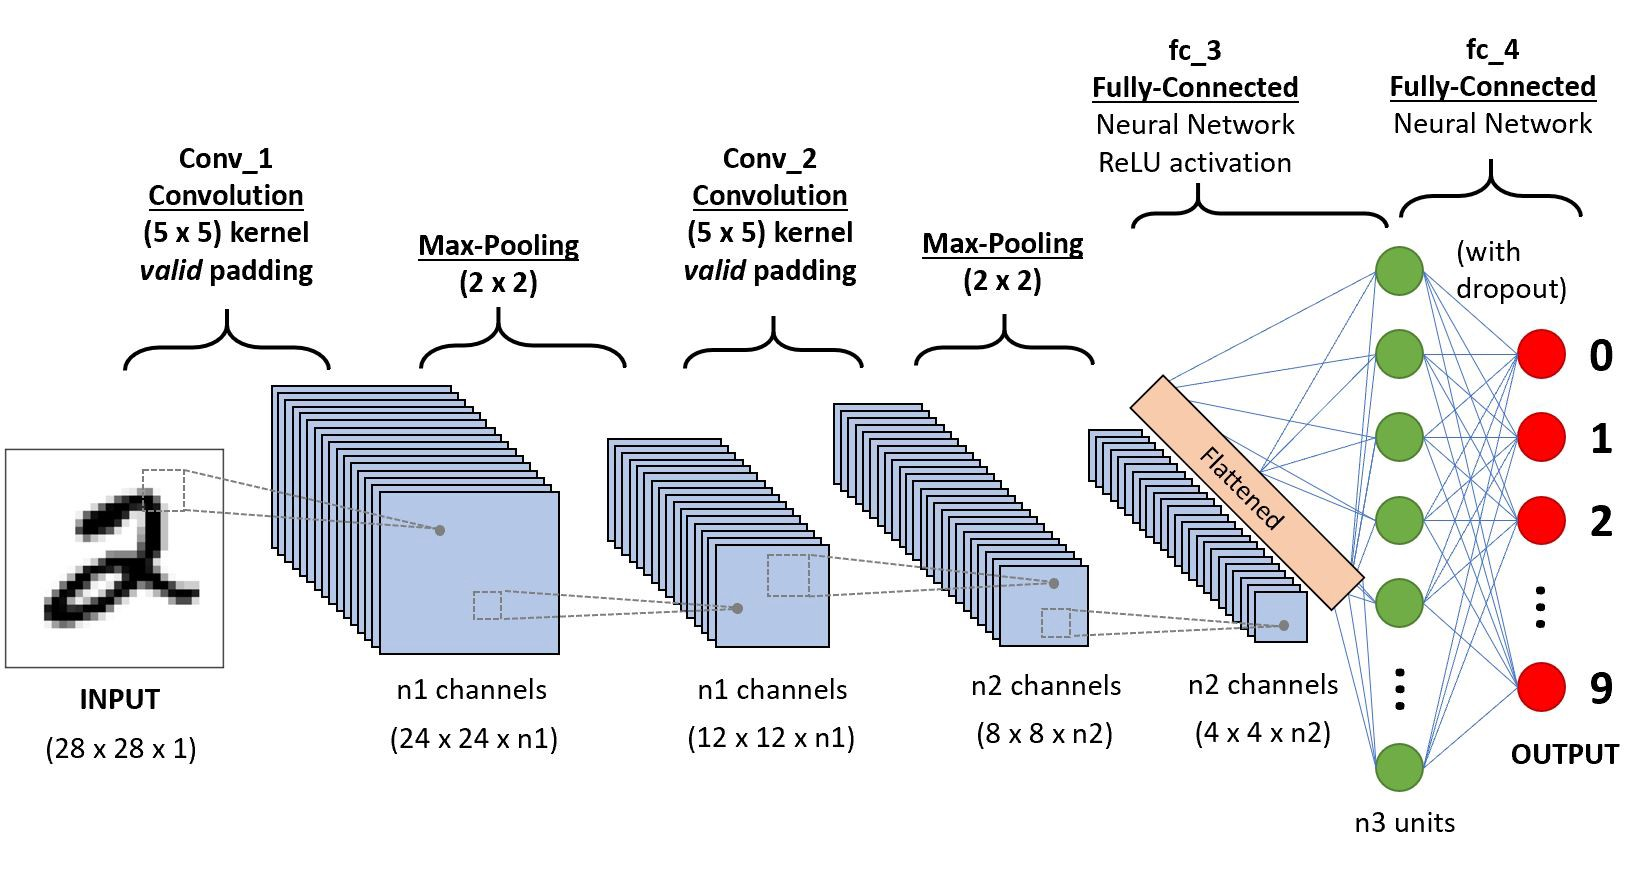

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same',activation='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))



model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))


In [ ]:
model.summary()

In [ ]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [ ]:
model.compile(optimizer=optimizer,loss=['categorical_crossentropy'],metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [ ]:
epochs=30 
batch_size=64

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (test_x,test_y),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
fig,ax=plt.subplots(2,1)
fig.set
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')
ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')

In [ ]:
y_pre_test=model.predict(test_x)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(test_y,axis=1)

In [ ]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))

In [ ]:
conf

In [ ]:
test=pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

test_id=test.id

test=test.drop('id',axis=1)
test=test/255
test=test.values.reshape(-1,28,28,1)




In [ ]:
y_pre=model.predict(test)     ##making prediction
y_pre=np.argmax(y_pre,axis=1) ##changing the prediction intro labels

In [ ]:
sample_sub['label']=y_pre
sample_sub.to_csv('submission.csv',index=False)

In [ ]:
sample_sub.head()